In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()  # 启动eager_execution

ValueError: tf.enable_eager_execution must be called at program startup.

'\n功能：Get Started with Eager Execution\n网址：https://www.tensorflow.org/get_started/eager\n时间：2018年04月19日14:05:44\n'

In [4]:
print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.7.0
Eager execution: True


In [5]:
# 查看训练数据
iris_training = "data/iris_training.csv"
data = pd.read_csv(iris_training)
data.head()

FileNotFoundError: File b'data/iris_training.csv' does not exist

In [25]:
def parse_csv(line):
    example_defaults = [[0.], [0.], [0.], [0.], [0]]  # 设置字段类型
    parsed_line = tf.decode_csv(line, example_defaults)
    features = tf.reshape(parsed_line[:-1], shape=(4,))  # 抽取前四列特征
    label = tf.reshape(parsed_line[-1], shape=())  # 抽取最后一列标签
    return features, label

In [26]:
# 生成训练集
train_dataset = tf.data.TextLineDataset(iris_training)
train_dataset = train_dataset.skip(1)             # skip the first header row
train_dataset = train_dataset.map(parse_csv)      # parse each row
train_dataset = train_dataset.shuffle(buffer_size=1000)  # randomize
train_dataset = train_dataset.batch(32)

# View a single example entry from a batch
features, label = tfe.Iterator(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

example features: tf.Tensor([5.2 3.5 1.5 0.2], shape=(4,), dtype=float32)
example label: tf.Tensor(0, shape=(), dtype=int32)


In [27]:
# 训练模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=(4,)),  # input shape required
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(3)
])

In [28]:
# loss函数
def loss(model, x, y):
    y_ = model(x)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)
    return loss

In [29]:
# 梯度函数
def grad(model, inputs, targets):
    with tfe.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

In [30]:
# 优化器
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

In [31]:
# 训练
train_loss_results = []  # loss记录
train_accuracy_results = []  # accuracy记录

num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

    # Training loop - using batches of 32
    for x, y in tfe.Iterator(train_dataset):
        # Optimize the model
        grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables),
                                  global_step=tf.train.get_or_create_global_step())

        # Track progress
        epoch_loss_avg(loss(model, x, y))  # add current batch loss
        # compare predicted label to actual label
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                    epoch_loss_avg.result(),
                                                                    epoch_accuracy.result()))

Epoch 000: Loss: 1.542, Accuracy: 35.000%
Epoch 050: Loss: 0.446, Accuracy: 76.667%
Epoch 100: Loss: 0.306, Accuracy: 95.833%
Epoch 150: Loss: 0.201, Accuracy: 97.500%
Epoch 200: Loss: 0.147, Accuracy: 98.333%


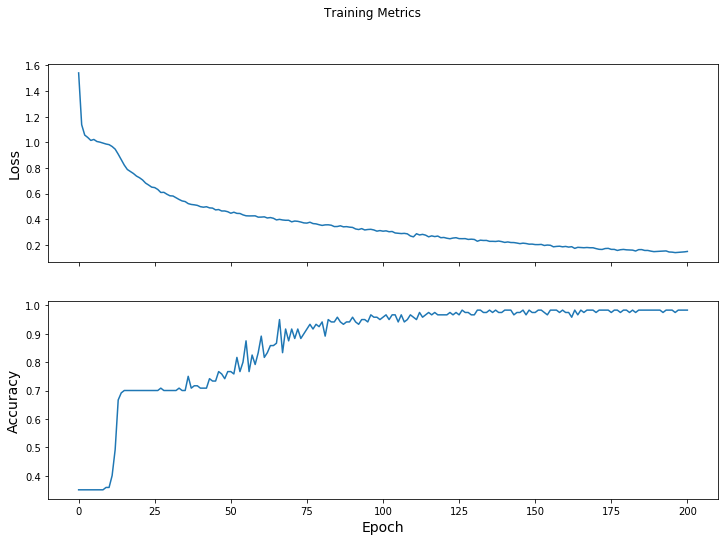

In [32]:
# 绘制Loss和Accuracy图
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

In [33]:
test_fp = "data/iris_test.csv"

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)  # skip header row
test_dataset = test_dataset.map(parse_csv)  # parse each row with the funcition created earlier
test_dataset = test_dataset.shuffle(1000)  # randomize
test_dataset = test_dataset.batch(32)  # use the same batch size as the training set

test_dataset

<BatchDataset shapes: ((?, 4), (?,)), types: (tf.float32, tf.int32)>

In [34]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in tfe.Iterator(test_dataset):
    prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


In [35]:
# 预测未知数据
class_ids = ["Iris setosa", "Iris versicolor", "Iris virginica"]

predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5, ],
    [5.9, 3.0, 4.2, 1.5, ],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    name = class_ids[class_idx]
    print("Example {} prediction: {}".format(i, name))

Example 0 prediction: Iris setosa
Example 1 prediction: Iris versicolor
Example 2 prediction: Iris virginica
